## Overview

In this notebook I am going to  demonstrate how to use **the TripletSemiHardLoss function** in TensorFlow Addons.

As presented in **the FaceNet paper**, TripletLoss is a loss function that trains a neural network **to closely embed features of the same class while maximizing the distance between the embeddings of different classes**. For this purpose an anchor is selected together with a negative and a positive sample. 

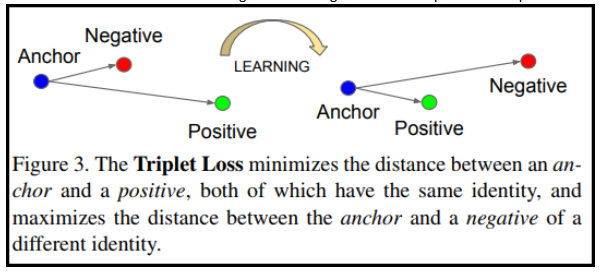

The loss function is described as **a Euclidean distance function**:
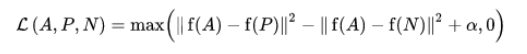

Where A is our anchor input, P is the positive sample input, N is the negative sample input, and alpha is some margin we use to specify when a triplet has become too "easy" and we no longer want to adjust the weights from it.

## SemiHard Online Learning 

As shown in the paper, the best results are from triplets known as **"Semi-Hard"**. These are defined as triplets where the negative is farther from the anchor than the positive, but still produces a positive loss. To efficiently find these triplets we utilize online learning and only train from the Semi-Hard examples in each batch bigger than 1000.
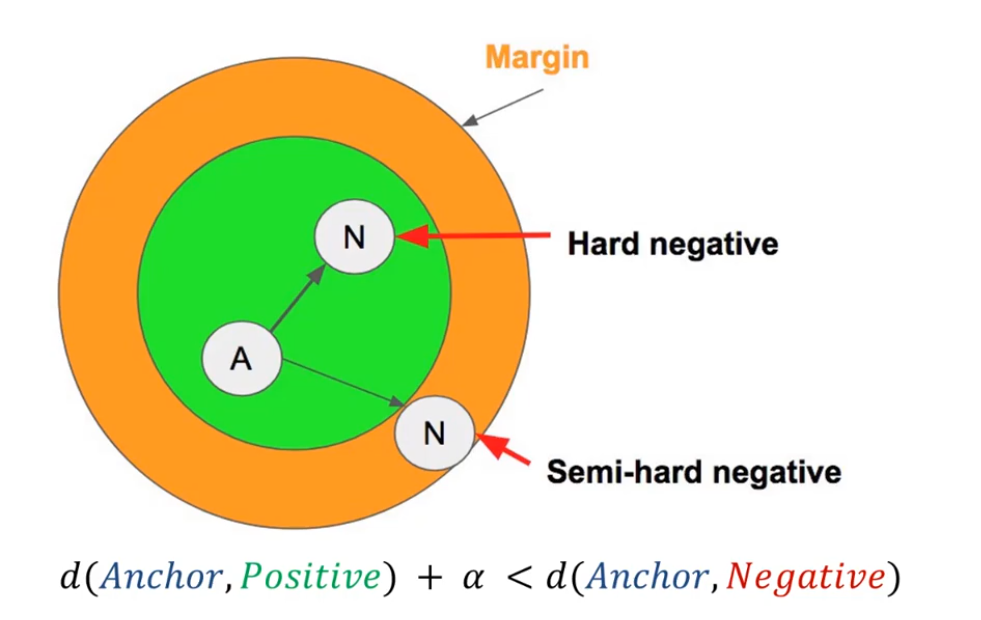

In [4]:
#!pip install -q tensorflow_datasets
#!pip install tensorflow-addons==0.9.1
#!pip install tensorflow==2.1


In [74]:
import numpy as np
import io
import os
import tensorflow.keras
import tensorflow_datasets as tfds
import tensorflow as tf
import tensorflow_addons as tfa
from tensorboard.plugins import projector

In [75]:
tf.__version__

'2.1.0'

# Prepare The dataset

In [76]:
def normalize_img(img,label):
    img = tf.cast(img, tf.float32)
    return img, label

train_dataset, test_dataset = tfds.load('mnist', split=['train', 'test'], as_supervised=True)

# Build your input pipelines
train_dataset = train_dataset.shuffle(1024).batch(256)
train_dataset = train_dataset.map(normalize_img)

test_dataset = test_dataset.shuffle(1024).batch(256)
test_dataset = test_dataset.map(normalize_img)

## Build the Model
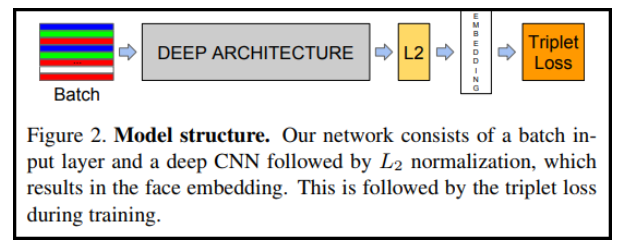

In [77]:
model =tf.keras.Sequential ()
model.add(tf.keras.layers.Conv2D(64,kernel_size=2, padding='same', activation='relu', input_shape=(28,28,1)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(.3))
model.add(tf.keras.layers.Conv2D(32,kernel_size=2, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(.3))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation=None))
model.add(tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)))# L2 normalize embeddings
         


## Train and Evaluate


Computes the triplet loss with semi-hard negative mining.

The loss encourages the positive distances (between a pair of embeddings
with the same labels) to be smaller than the minimum negative distance
among which are at least greater than the positive distance plus the
margin constant (called semi-hard negative) in the mini-batch.
If no such negative exists, uses the largest negative distance instead.
See: https://arxiv.org/abs/1503.03832.


We expect labels `y_true` to be provided as 1-D integer `Tensor` with shape
[batch_size] of multi-class integer labels. And embeddings `y_pred` must be
2-D float `Tensor` of l2 normalized embedding vectors.



Args:
  margin: Float, margin term in the loss definition. Default value is 1.0.

In [95]:

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tfa.losses.TripletSemiHardLoss())

In [96]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 64)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 32)        8224      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1568)             

In [97]:
# Train the network
history = model.fit(
    train_dataset,
    epochs=20)

Epoch 1/20
235/235 [==============================] - 130s 553ms/step - loss: 0.4780
Epoch 2/20
235/235 [==============================] - 119s 508ms/step - loss: 0.4685
Epoch 3/20
235/235 [==============================] - 120s 512ms/step - loss: 0.4647
Epoch 4/20
235/235 [==============================] - 119s 507ms/step - loss: 0.4621
Epoch 5/20
235/235 [==============================] - 119s 508ms/step - loss: 0.4537
Epoch 6/20
235/235 [==============================] - 120s 511ms/step - loss: 0.4531
Epoch 7/20
235/235 [==============================] - 119s 508ms/step - loss: 0.4493
Epoch 8/20
235/235 [==============================] - 120s 510ms/step - loss: 0.4502
Epoch 9/20
235/235 [==============================] - 120s 510ms/step - loss: 0.4475
Epoch 10/20
235/235 [==============================] - 121s 513ms/step - loss: 0.4478
Epoch 11/20
235/235 [==============================] - 119s 507ms/step - loss: 0.4460
Epoch 12/20
235/235 [==============================] - 120s 510


## Visualizing Data using the Embedding Projector in TensorBoard

Using the TensorBoard Embedding Projector, I can graphically represent high dimensional embeddings. This can be helpful in visualizing, examining, and understanding your embedding layers.


In [98]:
# Evaluate the network
results = model.predict(test_dataset)
results.shape

(10000, 256)

In [99]:
log_dir='/logs/FaceNet/'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

In [100]:
out_meta = io.open(log_dir + 'meta.tsv', 'w', encoding='utf-8')
for img, labels in tfds.as_numpy(test_dataset):
    [out_meta.write(str(x)+'\n') for x in labels]
    
out_meta.close()

In [101]:
# Create a checkpoint from embedding, the filename and key are
# name of the tensor.
checkpoint = tf.train.Checkpoint(embedding=tf.Variable(results))
checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))

'/logs/FaceNet/embedding.ckpt-1'

In [102]:
# Set up config

config = projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = 'meta.tsv'
projector.visualize_embeddings(log_dir, config)

In [103]:
%load_ext tensorboard
%tensorboard --logdir /logs/FaceNet/


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 22572), started 1:22:32 ago. (Use '!kill 22572' to kill it.)

# Test Model on the Fashion MNIST dataset

In [104]:
(f_train_images, f_train_labels), (f_test_images, f_test_labels) = tf.keras.datasets.fashion_mnist.load_data()
print(f_test_images.shape)
print(f_test_labels.shape)

(10000, 28, 28)
(10000,)


In [105]:
f_test_images.shape

(10000, 28, 28)

In [ ]:
loss = model.evaluate(np.expand_dims(f_test_images,3),f_test_labels, batch_size=32, verbose=2)
print('loss:', loss)


Copyright 2019 The TensorFlow Authors.¶
